# Workflow for text analysis from PDF

Formalizing the workflow from various projects into a workflow that can be applied to various texts, including longer form documents from PDF.

<a target="_blank" href="https://colab.research.google.com/github/arielsaffer/pest-text-pipeline/blob/main/notebooks/text_mining_workflow.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Steps

0. Set up the workspace
1. Extract text from PDF to produce a corpus of "documents" (e.g., pages, paragraphs, sentences)
2. Apply exploratory text analysis: Topic modeling (LDA) and keyword search (regex), Lexical dispersion plot 
3. Machine learning to select for topics about presence.
4. Geoparsing to extract locations from presence records.
5. Visualize results

## 0. Set up the workspace

Define where you will be running the notebook:

"Local" assumes that you have cloned the full Github repository to your local machine. "Colab" assumes that you are running this notebook on Google Colab.



In [1]:
# @titleDefine where you will be running the notebook. { display-mode: "form" }

run_on = "Local"  # @param ["Local", "Colab"]
print("You will run the notebook on", run_on)

You will run the notebook on Local


In [2]:
# Import general libraries

import pandas as pd
import pickle
import plotly.express as px

pd.set_option('display.max_colwidth', 100)

# Set up workspace

if run_on == "Local":
    # Set up pytesseract
    import os
    import pytesseract
    os.chdir("..")
    # This should be the path of the tesseract installation
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
    import text_analysis.data_functions as ta
    
elif run_on == "Colab":
    # Setup Google Drive mount
    from google.colab import drive
    drive.mount('/content/drive')

    # Install required programs and packages
    !sudo apt install tesseract-ocr
    !pip install pytesseract
    !pip install pdf2image
    !pip install tomotopy
    !python -m spacy download en_core_web_md

    # Import the data functions from the Github repository
    !git clone https://github.com/arielsaffer/pest_text_pipeline.git
    import pest_text_pipeline.text_analysis.data_functions as ta
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asaffer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# @title Describe the PDF file. { display-mode: "form" }
# @markdown Provide the location of the PDF file to be processed
# @markdown Either a local path, relative path (to the repository root),
# @markdown or a Google Drive path (typically starts with "/content/drive/My Drive/")

file_location = r"data"  # @param {type:"string", placeholder:"data"}
pdf_name = r"DowleyBook6.19.24.pdf"  # @param {type:"string", placeholder:"DowleyBook6.19.24.pdf"}

# @markdown Provide the language of the text
language = "English"  # @param ['Afrikaans', 'Amharic', 'Arabic', 'Assamese', 'Azerbaijani', 'Azerbaijani - Cyrilic', 'Belarusian', 'Bengali', 'Tibetan', 'Bosnian', 'Breton', 'Bulgarian', 'Catalan; Valencian', 'Cebuano', 'Czech', 'Chinese - Simplified', 'Chinese - Traditional', 'Cherokee', 'Corsican', 'Welsh', 'Danish', 'German', 'German (Fraktur Latin)', 'Dzongkha', 'Greek, Modern (1453-)', 'English', 'English, Middle (1100-1500)', 'Esperanto', 'Math / equation detection module', 'Estonian', 'Basque', 'Faroese', 'Persian', 'Filipino (old - Tagalog)', 'Finnish', 'French', 'German - Fraktur (now deu_latf)', 'French, Middle (ca.1400-1600)', 'Western Frisian', 'Scottish Gaelic', 'Irish', 'Galician', 'Greek, Ancient (to 1453) (contrib)', 'Gujarati', 'Haitian; Haitian Creole', 'Hebrew', 'Hindi', 'Croatian', 'Hungarian', 'Armenian', 'Inuktitut', 'Indonesian', 'Icelandic', 'Italian', 'Italian - Old', 'Javanese', 'Japanese', 'Kannada', 'Georgian', 'Georgian - Old', 'Kazakh', 'Central Khmer', 'Kirghiz; Kyrgyz', 'Kurmanji (Kurdish - Latin Script)', 'Korean', 'Korean (vertical)', 'Lao', 'Latin', 'Latvian', 'Lithuanian', 'Luxembourgish', 'Malayalam', 'Marathi', 'Macedonian', 'Maltese', 'Mongolian', 'Maori', 'Malay', 'Burmese', 'Nepali', 'Dutch; Flemish', 'Norwegian', 'Occitan (post 1500)', 'Oriya', 'Orientation and script detection module', 'Panjabi; Punjabi', 'Polish', 'Portuguese', 'Pushto; Pashto', 'Quechua', 'Romanian; Moldavian; Moldovan', 'Russian', 'Sanskrit', 'Sinhala; Sinhalese', 'Slovak', 'Slovenian', 'Sindhi', 'Spanish; Castilian', 'Spanish; Castilian - Old', 'Albanian', 'Serbian', 'Serbian - Latin', 'Sundanese', 'Swahili', 'Swedish', 'Syriac', 'Tamil', 'Tatar', 'Telugu', 'Tajik', 'Thai', 'Tigrinya', 'Tonga', 'Turkish', 'Uighur; Uyghur', 'Ukrainian', 'Urdu', 'Uzbek', 'Uzbek - Cyrilic', 'Vietnamese', 'Yiddish', 'Yoruba']
# @markdown Determine how the document should be subdivided ("page", "paragraph", or "sentence")
document_level = "paragraph"  # @param ["page", "paragraph", "sentence"]

In [5]:
# Check that the file exists
pdf_path = os.path.join(file_location, pdf_name)

# Map langauge to the OCR code and name in NLTK

ocr_code, nltk_lang, spacy_code = ta.map_language(language)

if not os.path.exists(pdf_path):
    raise FileNotFoundError(
        f"File {pdf_path} not found! Please double-check the location."
    )
else:
    print(f"You will analyze {pdf_path} in {language} at the {document_level} level")

You will analyze data\DowleyBook6.19.24.pdf in English at the paragraph level


### 1. Extract text from PDF to produce a corpus of documents

In [ ]:
text_corpus = ta.pdf_to_corpus(
    pdf_path=pdf_path, lang=ocr_code, document_level=document_level
)

In [12]:
# Look at the result

text_corpus

,Text
0,THE FARMERS GAZETTE References to THE FAMINE PERIOD AND POTATO DISEASES IN IRELAND 1844-1847 ...
1,Dowley from the Farmers Gazette and Journal of Practical Horticulture 1844-1847 Department of...
2,"Landscape Gardener Published every Saturday morning at 23 Bachelors Walk, Dublin January 2011 ..."
3,"At home, the Gazette regularly reported the proceedings of the Royal Agricultural Improvement S..."
4,It is true that the control and membership of the above societies were largely in the hands of t...
...,...
8280,"Also from John Dillon Croker, Esq., Mallow, enclosing sonie excellent specimens of bread made pa..."
8281,"Also from William Phibbs, Esc., Seafield, Sligo, enclosing a report from Mr"
8282,"Cooper of Markree, on the subjects; all which communications, together with various others were ..."
8283,The secretary stated that he had received numerous returns from the local societies in reply to...


In [31]:
# Because this is a scanned text, you may need to do some
# additional cleaning.

# For example, I noticed that " | " appears intead of "I " in the text

text_corpus["Text"] = text_corpus["Text"].str.replace("\b\|\b", "I", regex=True)


# And " O " and " OQ " appear, probably where there were marks on the page

text_corpus["Text"] = text_corpus["Text"].str.replace(" OQ ", "", regex=False)
text_corpus["Text"] = text_corpus["Text"].str.replace(" O ", "", regex=False)
text_corpus["Text"] = text_corpus["Text"].str.replace(" QO ", "", regex=False)

In [17]:
# Save the text corpus to a CSV file

text_corpus.to_csv(f"{pdf_path[:-4]}_{document_level}.csv", index=False)

### 2. Apply exploratory text analysis: topic modeling (LDA), keyword search (regex)

#### LDA

In [6]:
# You can restart here by loading your text-corpus from the CSV file

text_corpus = pd.read_csv(f"{pdf_path[:-4]}_{document_level}.csv")

In [22]:
topic_table = ta.text_to_topics(
    text_corpus["Text"], lang=nltk_lang, num_topics=20, num_iter=10
)


# 10 iterations here just for texting, should be higher in practice

Text data preprocessed (tokenized, lowercased, stopwords removed).


Topic Model Training...


Iteration: 0	Log-likelihood: -9.356104189489258
Iteration: 1	Log-likelihood: -9.087671357995603
Iteration: 2	Log-likelihood: -8.92950738336612
Iteration: 3	Log-likelihood: -8.851733474641065
Iteration: 4	Log-likelihood: -8.792270440067417
Iteration: 5	Log-likelihood: -8.770231976723602
Iteration: 6	Log-likelihood: -8.741254776723668
Iteration: 7	Log-likelihood: -8.713777518791224
Iteration: 8	Log-likelihood: -8.698384516607549
Iteration: 9	Log-likelihood: -8.687894034474917
Top 10 words for each topic extracted.


In [23]:
# Look at the topics
topic_table

# Add topic prevalence/probability
# Show change in language over time (lexical dispersion plot)
# Failure, then management

,Topic Number,Top Words
0,0,"[may, much, great, best, would, land, use, necessary, place, mode]"
1,1,"[much, potato, cause, may, yet, far, disease, less, many, crop]"
2,2,"[would, us, one, let, give, part, little, well, man, class]"
3,3,"[every, must, cannot, could, even, would, many, great, means, public]"
4,4,"[present, food, people, may, country, state, must, means, ireland, cannot]"
5,5,"[potato, farmers, page, disease, crop, potatoes, november, failure, october, pages]"
6,6,"[potatoes, diseased, sound, seed, found, one, quite, two, many, taken]"
7,7,"[per, would, ireland, acres, produce, year, grain, average, fair, corn]"
8,8,"[mr, meeting, society, lord, council, also, agricultural, general, letter, different]"
9,9,"[one, potatoes, two, dry, kept, good, laid, mixed, three, lime]"


#### Keyword search

In [6]:
# Define keywords you are interested in using to search for relevant text

hunger_keywords = ["famine", "hunger", "hungry", "shortage", "starv"]

In [10]:
# Search for the keywords

ta.keyword_search(text_data=text_corpus["Text"], keywords=hunger_keywords)

,Text,Keywords Found
11,"In the potato, the main diseases prior to the famine were potato leaf roll virus (Curl), black-...",True
15,In the period leading up to the famine the main disease referred to in the Gazette appeared to ...,True
228,"A tour of the area around Kilberry Cross, near Navan, in August 1980 reminded me very much of wh...",True
295,"It is quite certain that starch, or materials corresponding to it, exist to _ acertain amount in...",True
407,It may be as a result of this criticism that their utterances on the potato problem seemed to di...,True
...,...,...
8103,"The conference covered all aspects of research on Phytophthora infestans, including the scientif...",True
8108,What was the Farmers Gazette? The Farmers Gazette and Journal of Practical Horticulture was an...,True
8111,"Given the absence of modern means of communication at the time of the famine, it is extraordinar...",True
8202,"Potatoes being their all, their sole subsistence—if they fail, the people look in terror to a fa...",True


#### Lexical dispersion

Visualize the occurence of keywords throughout the text

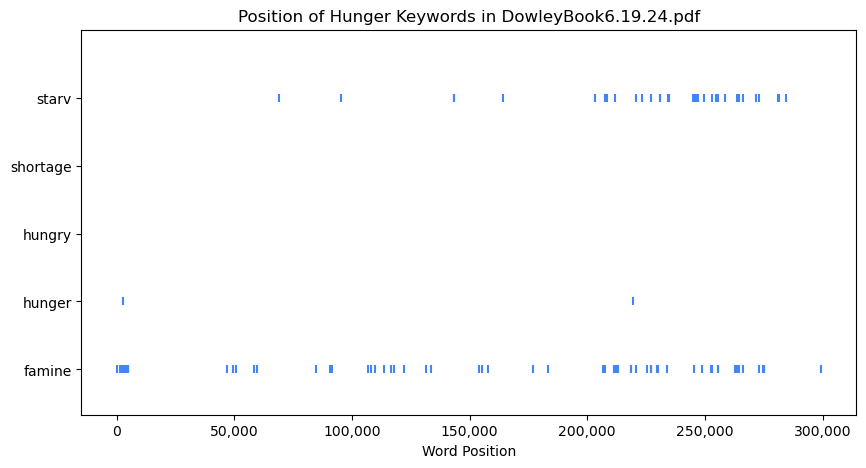

In [31]:
ta.plot_dispersion(
    text_corpus["Text"],
    keywords=hunger_keywords,
    title=f"Position of Hunger Keywords in {os.path.basename(pdf_path)}",
)

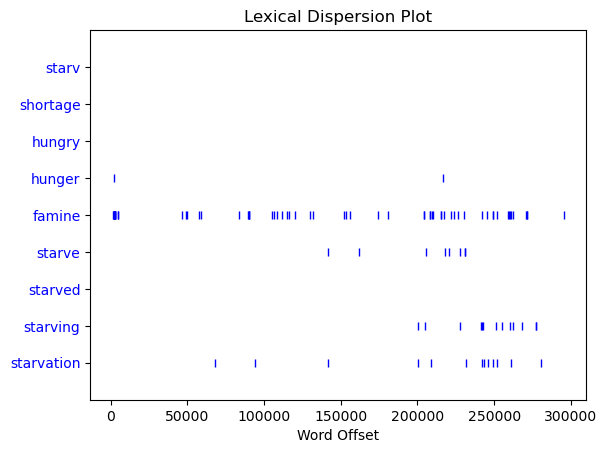

In [35]:
# NLTK version
# Similar (faster) but only provides exact matches
# and a little harsh on the eyes
import nltk

nltk_corpus = nltk.Text(nltk.word_tokenize("".join(text_corpus["Text"])))
nltk_corpus.dispersion_plot(
    hunger_keywords + ["starve", "starved", "starving", "starvation"]
)

## 3. Machine learning to select for topics about presence

In [36]:
# Since I don't have labeled data, here I am just going to consider all posts with
# "disease report keywords" as positives.
# These are very imperfect! (e.g., "report", "found", and "present" have many common uses)
# These could be refined, or more ideally, a small sample of posts should be labeled manually

disease_report_keywords = [
    "report",
    "found",
    "suffer",
    "loss",
    "present",
    "disease",
]

# Add a Label column

text_corpus["Label"] = 0

# Set the label to 1 if any of the keywords are in the text

positive_locs = ta.keyword_search(
    text_data=text_corpus["Text"], keywords=disease_report_keywords
).index

text_corpus.loc[positive_locs, "Label"] = 1

# Take a stratified sample of 20% of the data as our "labeled data"

labeled_data = (
    text_corpus.groupby("Label", group_keys=False)
    .apply(lambda x: x.sample(frac=0.2))
    .reset_index(drop=True)
)

In [37]:
# Take a look at the labeled data

labeled_data

,Text,Label
0,"Garden further says—"" It is quite possible that my letter may have been likely to mar the prospe...",0
1,"Dig your potatoes in dry weather, if you can; and if you cannot, get them dry somehow as fast as...",0
2,"I fear the recommendation of leading politicians to get rid of the small farmer of Ireland, and...",0
3,The letter is sufficiently plain,0
4,"238 INDIAN CORN Farmers Gazette, February 14, 1846, page 682 sIR—As there is some prospect of...",0
...,...,...
1652,"Charred turf is not good, but wherever I find a wet pit either here (the model farm) or with th...",1
1653,"Instances of accidental application of salt for other purposes preventing disease, when adjoinin...",1
1654,"I have been lately through the counties of Galway, Roscommon, Westmeath, Kildare, Dublin, Meath...",1
1655,"Rogers does not come before the public as a theorist, and experience should have its proper weig...",1


In [38]:
# Test several models for classification

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier

# Define the models to test

models = [LinearSVC(), LogisticRegression(), ComplementNB(), DecisionTreeClassifier()]

# Define the vectorizer

vectorizer = TfidfVectorizer(stop_words="english", min_df=0.001, ngram_range=(1, 2))

In [39]:
# @title Define the metric that will be used to select the top model. { display-mode: "form" }

selection_metric = "fscore"  # @param ["accuracy", "precision", "recall", "fscore"]

In [40]:
# Test the models

model_testing_df = ta.test_multiple_models(
    X=labeled_data["Text"],
    y=labeled_data["Label"],
    models=models,
    vectorizer=vectorizer,
    k=10,
    random_state=40,
)

# Look at the results

model_testing_df

,model,accuracy,accuracy_sd,precision,precision_sd,recall,recall_sd,fscore,fscore_sd
3,DecisionTreeClassifier(),0.928167,0.015693,0.811326,0.051849,0.807027,0.088169,0.806436,0.058516
0,LinearSVC(),0.923921,0.019677,0.936888,0.068357,0.650847,0.078038,0.764158,0.059485
1,ComplementNB(),0.796605,0.023947,0.476895,0.100424,0.628058,0.089306,0.539344,0.094121
2,LogisticRegression(),0.841230,0.028078,0.915714,0.079446,0.200735,0.052630,0.325766,0.074215


In [41]:
# Apply the best model to the full text corpus

best_model = model_testing_df.loc[model_testing_df[selection_metric].idxmax(), "model"]

# Train the best model on the full labeled data

best_model.fit(
    X=vectorizer.fit_transform(labeled_data["Text"]), y=labeled_data["Label"]
)

# Predict the labels for the full text corpus

text_corpus["Predicted_Label"] = best_model.predict(
    vectorizer.transform(text_corpus["Text"])
)

In [42]:
# Show the positive results

text_corpus.loc[text_corpus["Predicted_Label"] == 1]

,Text,Label,Predicted_Label
0,THE FARMERS GAZETTE References to THE FAMINE PERIOD AND POTATO DISEASES IN IRELAND 1844-1847 ...,0,1
3,"At home, the Gazette regularly reported the proceedings of the Royal Agricultural Improvement S...",1,1
9,The frequent references to failures and diseases of the crop highlight the importance of these a...,1,1
10,References to Potato Diseases Prior to Late Blight While the discipline of Plant Pathology was...,1,1
11,"In the potato, the main diseases prior to the famine were potato leaf roll virus (Curl), black-...",1,1
...,...,...,...
8275,"The Secretary read a number of letters, from various quarters, in reference to the potato disea...",1,1
8276,"A letter was also read from Professor Johnston, of Durham, requesting to be made acquainted wit...",1,1
8279,"A communication was also read from the Lord Lieutenant, enclosing a letter detailing the ""resul...",1,1
8281,"Also from William Phibbs, Esc., Seafield, Sligo, enclosing a report from Mr",1,1


## 4. Geoparsing to extract locations from presence records

This process involves three mains steps:
1. Extracting all location entities from the text using Named Entity Recognition (NER)
2. Geocoding entities as-is, and using post context and the post origin country
3. Selecting the most likely location 

In [7]:
# Load the language-specific spaCy NER model
# This will use the same language identified earlier for the document

nlp = ta.load_lang_nlp(spacy_code)

# Extract locations from the text

text_corpus["all_locs"] = text_corpus["Text"].apply(lambda x: ta.get_loc_ents(x, nlp, origin="Ireland"))

In [37]:
# Geocode the locations in the text
# This step relies on the OSM Nominatim API, which has a rate limit (1 request per second)
# so this will take some time if there are a large number of unique locations

# You will need to input a user agent (e.g. "pest-text-pipeline", "p-infestans-analysis") when prompted)

# Unnest the doubly-nested lists of lists into a single list of unique locations
unique_locations = [loc for sublist in text_corpus["all_locs"].dropna() for loc in sublist]
unique_locations = set([loc for sublist in unique_locations for loc in sublist])

print(len(unique_locations), "unique location names found in the text.")

geo_loc_dict, error_locations = ta.geocode_locs(list(unique_locations))

print(f"{len(geo_loc_dict)} location names successfully geocoded, {len(error_locations)} location names not found.")

# Save the geo_loc_dict with pickle to avoid re-running the geocoding

with open(f"{pdf_path[:-4]}_geo_loc_dict.pkl", "wb") as f:
    pickle.dump(geo_loc_dict, f)
    

833 unique location names found in the text.
1: POTATOES Farmers Gazette, Ireland not found.
2: Ballieborough not found.
3: Hartpool, Ireland not found.


RateLimiter caught an error, retrying (0/2 tries). Called with (*('D.L., Ireland',), **{}).
Traceback (most recent call last):
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\site-packages\urllib3\connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\site-packages\urllib3\connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 1375, in getresponse
    response.begin()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\

4: D.L., Ireland not found.
5: Pinkeyes not found.
6: Universal Prussian Gazette, Ireland not found.
7: Maryville, Croom not found.
8: the British Isles, Ireland not found.
9: Sounders, Ireland not found.
10: Marum, Ireland not found.
11: Esq, Limerick not found.
12: the Farmers Gazette, Ireland not found.
13: well.—Yours not found.
14: Bart, .Coates not found.
15: Clare, Mount Shannon not found.
16: Campbeltown, Ireland not found.
17: 6th Victoria, Ireland not found.
18: the east coast, Ireland not found.
19: Premising, Ireland not found.
20: early York, Ireland not found.
21: Longforgan, Ireland not found.
22: manner:—Place, Ireland not found.
23: Glenelg, Ireland not found.
24: Monilia, Ireland not found.
25: Pebble O'Keefe not found.
26: Oporto, Ireland not found.
27: North America, Ireland not found.
28: Guelderland, Ireland not found.
29: Esqrs, Ireland not found.
30: Philadelphia, Ireland not found.
31: Bantry, Pebble O'Keefe not found.
32: Cullenagh, Maryborough not found.
33: 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('the River Plate, Ireland',), **{}).
Traceback (most recent call last):
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\site-packages\urllib3\connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\site-packages\urllib3\connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 1375, in getresponse
    response.begin()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "c:\Users\asaffer\AppData\Local\minic

65: the River Plate, Ireland not found.
66: Pampas, Ireland not found.
67: Agricultural Gazette not found.
68: Jamess Haughton, Ireland not found.
69: Hardgrave, Ireland not found.
70: Strontain not found.
71: Limerick, Belfast not found.
72: Renfrewshire, Agriculturist not found.
73: Ichaboe, Ireland not found.
74: Thornville, Limerick not found.
75: aToid not found.
76: Ayrshire Agriculturist not found.
77: Premising not found.
78: Farmers Gazette, Ireland not found.
79: Cracow, Ireland not found.
80: 6ih Viet, Ireland not found.
81: Esq, Dublin not found.
82: Azores, Oporto not found.
83: Balbriggan, Newry not found.
84: Persia, Ireland not found.
85: Africa, Labrador not found.
86: 9th Viet, Ireland not found.
87: the Kingdom of New Spain, Ireland not found.
88: New Grenada, Ireland not found.
89: Pinkeyes, Ireland not found.
90: Peebles- shire, Ireland not found.
91: Tervo, Ireland not found.
92: Brazils, Ireland not found.
93: Esq, Ballynanty not found.
94: PLANTING Farmers Gazet

RateLimiter caught an error, retrying (0/2 tries). Called with (*('D.S., Ireland',), **{}).
Traceback (most recent call last):
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\site-packages\urllib3\connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\site-packages\urllib3\connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 1375, in getresponse
    response.begin()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\NLP\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "c:\Users\asaffer\AppData\Local\miniconda3\envs\

134: D.S., Ireland not found.
135: Guelderland not found.
136: Hartpool not found.
137: Gazetfe, Ireland not found.
138: Psilonia, Ireland not found.
139: AUTUMN Farmers Gazette not found.
140: North Brabant, Ireland not found.
141: quito, Ireland not found.
142: 10th Victoria, Ireland not found.
143: Thomas Birmingham, Ireland not found.
144: Shewalton, Ireland not found.
145: Aberdeenshire, Ireland not found.
146: IRELAND Farmers Gazette not found.
147: Agricultural Gazette, Ireland not found.
148: Merulias not found.
149: well.—Yours, Ireland not found.
150: manner:—Place not found.
151: Esqrs not found.
152: Holand, Ireland not found.
153: POTATOES Farmers Gazette not found.
154: Beere, Esq not found.
155: Windsor Castle, Ireland not found.
156: Hodson, Bart not found.
157: P. Garden, Ireland not found.
158: Glenelg, Orkney not found.
159: Pebble O'Keefe, Ireland not found.
160: Bristol, London not found.
161: the Pentland Hills, Ireland not found.
162: Cambridgeshire, Ireland not 

 Many of the not-found locations are clearly not locations (e.g., "PLANTING Farmers Gazette", "manner:—Place, Ireland"), or combinations that don't make sense (e.g., "North America, Ireland"). We can safely ignore these. 
 
 However, some are missed locations due to naming or spelling (e.g., "the Bay of Wigton" -> which is "Wigton Bay"). Those "true locations" can be manually corrected and then re-geocoded.

 There are also cases where non-locations are successfully geocoded (e.g., D.S. -> Disney Springs, Florida), and will need to be filtered out. 

In [39]:
# Read in the geo_loc_dict from the file, if it exists

if os.path.exists(f"{pdf_path[:-4]}_geo_loc_dict.pkl"):
    with open(f"{pdf_path[:-4]}_geo_loc_dict.pkl", "rb") as f:
        geo_loc_dict = pickle.load(f)

In [61]:
# Filter to posts with locations

locations_corpus = text_corpus[text_corpus["all_locs"].apply(lambda x: len(x) > 0)]
locations_corpus = locations_corpus.explode("all_locs").reset_index(drop=True)

# Select the best location

locations_corpus["best_location"] = locations_corpus["all_locs"].apply(
    lambda x: ta.select_location(x[0], x[1], x[2], geo_loc_dict, prefer="original")
)

In [62]:
# Show the non-null values

locations_corpus[locations_corpus["best_location"].notnull()]

,Text,all_locs,best_location
0,THE FAMINE PERIOD AND POTATO DISEASES IN IRELAND 1844-1847,"[IRELAND, None, IRELAND, Ireland]","(Éire / Ireland, (52.865196, -7.9794599))"
1,"Published every Saturday morning at 23 Bachelors Walk, Dublin","[Dublin, None, Dublin, Ireland]","(Dublin, County Dublin, Leinster, Éire / Ireland, (53.3493795, -6.2605593))"
2,January 2011 CONTENTS Page Introduction 1 1844 Cause of failure in potatoes 7 Curl in potatoes ...,"[Bangor, None, Bangor, Ireland]","(Bangor, Penobscot County, Maine, 04401, United States, (44.8016255, -68.7713289))"
3,January 2011 CONTENTS Page Introduction 1 1844 Cause of failure in potatoes 7 Curl in potatoes ...,"[Bangor, None, Bangor, Ireland]","(Bangor, Penobscot County, Maine, 04401, United States, (44.8016255, -68.7713289))"
4,) poate cultivation 55 Potato failure 57 Potato failure 57 State of the weather and crops 58 On...,"[UK, None, UK, Ireland]",UK
...,...,...,...
1469,"Yours, &¢., JOHN J. GEOGHEGAN, Thomastown, Co, Tipperary, September 29, 1847.","[Tipperary, None, Tipperary, Ireland]","(County Tipperary, Munster, Éire / Ireland, (52.68482145, -7.898147186112796))"
1470,"[We are much obliged to our correspondent for his communication, notwithstanding there is nothin...","[Ireland, None, Ireland, Ireland]","(Éire / Ireland, (52.865196, -7.9794599))"
1472,"Yours, &c., W. BETHAM, V.P.li.D.S., Royal Dublin Society, October 8, 1847.","[W. BETHAM, W. BETHAM, V.P.li, W. BETHAM, Ireland]","(Betham, Gwangang Chata, Hawul, Borno, Nigeria, (10.3264206, 12.1017818))"
1473,"Yours, &c., W. BETHAM, V.P.li.D.S., Royal Dublin Society, October 8, 1847.","[V.P.li, V.P.li, D.S., V.P.li, Ireland]","(V&P, 15, Grootestraße, Dransdorf, Stadtbezirk Bonn, Bonn, Nordrhein-Westfalen, 53121, Deutschla..."


In [ ]:
locations_corpus["expanded_location"] = locations_corpus["best_location"].apply(ta.expand_geocoder_result)

locations_corpus["display_name"] = locations_corpus["expanded_location"].apply(lambda x: x[0])
locations_corpus["address_type"] = locations_corpus["expanded_location"].apply(lambda x: x[1])
locations_corpus["lat"] = locations_corpus["expanded_location"].apply(lambda x: x[2])
locations_corpus["lon"] = locations_corpus["expanded_location"].apply(lambda x: x[3])
locations_corpus["bounding_box"] = locations_corpus["expanded_location"].apply(lambda x: x[4])

locations_corpus = locations_corpus.drop(columns=["expanded_location", "best_location"])


In [114]:
locations_corpus

,Text,all_locs,display_name,address_type,lat,lon,bounding_box
0,THE FAMINE PERIOD AND POTATO DISEASES IN IRELAND 1844-1847,"[IRELAND, None, IRELAND, Ireland]",Éire / Ireland,country,52.865196,-7.9794599,"[51.2220000, 55.6360000, -11.0133788, -5.6582363]"
1,"Published every Saturday morning at 23 Bachelors Walk, Dublin","[Dublin, None, Dublin, Ireland]","Dublin, County Dublin, Leinster, Éire / Ireland",city,53.3493795,-6.2605593,"[53.2987342, 53.4105416, -6.3870259, -6.1148829]"
2,January 2011 CONTENTS Page Introduction 1 1844 Cause of failure in potatoes 7 Curl in potatoes ...,"[Bangor, None, Bangor, Ireland]","Bangor, Penobscot County, Maine, 04401, United States",city,44.8016255,-68.7713289,"[44.7775455, 44.8801777, -68.8590412, -68.7187359]"
3,January 2011 CONTENTS Page Introduction 1 1844 Cause of failure in potatoes 7 Curl in potatoes ...,"[Bangor, None, Bangor, Ireland]","Bangor, Penobscot County, Maine, 04401, United States",city,44.8016255,-68.7713289,"[44.7775455, 44.8801777, -68.8590412, -68.7187359]"
4,) poate cultivation 55 Potato failure 57 Potato failure 57 State of the weather and crops 58 On...,"[UK, None, UK, Ireland]",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1470,"[We are much obliged to our correspondent for his communication, notwithstanding there is nothin...","[Ireland, None, Ireland, Ireland]",Éire / Ireland,country,52.865196,-7.9794599,"[51.2220000, 55.6360000, -11.0133788, -5.6582363]"
1471,"Farmers Gazette, October 16th"", 1847, page 395","[Farmers Gazette, None, Farmers Gazette, Ireland]",NaN,NaN,NaN,NaN,NaN
1472,"Yours, &c., W. BETHAM, V.P.li.D.S., Royal Dublin Society, October 8, 1847.","[W. BETHAM, W. BETHAM, V.P.li, W. BETHAM, Ireland]","Betham, Gwangang Chata, Hawul, Borno, Nigeria",village,10.3264206,12.1017818,"[10.3064206, 10.3464206, 12.0817818, 12.1217818]"
1473,"Yours, &c., W. BETHAM, V.P.li.D.S., Royal Dublin Society, October 8, 1847.","[V.P.li, V.P.li, D.S., V.P.li, Ireland]","V&P, 15, Grootestraße, Dransdorf, Stadtbezirk Bonn, Bonn, Nordrhein-Westfalen, 53121, Deutschland",shop,50.7369423,7.0478455,"[50.7368923, 50.7369923, 7.0477955, 7.0478955]"


In [115]:
# Export the locations to a CSV file

locations_corpus.to_csv(f"{pdf_path[:-4]}_locations.csv", index=False)

### 5. Visualize results

In [99]:
# Keep only locations with a bounding box

coords_corpus = locations_corpus[locations_corpus["bounding_box"].notnull()]

# Turn lat and lon into floats

coords_corpus["lat"] = coords_corpus["lat"].astype(float)
coords_corpus["lon"] = coords_corpus["lon"].astype(float)

In [111]:
# @title Display the locations on a map. { display-mode: "form" }
# @markdown Provide your Mapbox access token. 
# @markdown You can create one with a free account at https://account.mapbox.com/access-tokens/

your_token = ""  # @param {type:"string"}

px.set_mapbox_access_token(your_token)
fig = px.scatter_mapbox(coords_corpus, lat="lat", lon="lon", zoom=3)
fig.update_traces(cluster=dict(enabled=True))
fig.show()